## DATA1030 Course Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from pathlib import Path

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

fig_save = Path("/Users/apple/Desktop/1030 midterm/figs")
fig_save.mkdir(parents=True, exist_ok=True)

### Part 1: Data Overview

In [2]:
df = pd.read_csv("/Users/apple/Desktop/1030 midterm/midterm dataset/brisbane_water_quality.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
df = df.sort_values("Timestamp").reset_index(drop=True)
df.head()

,Timestamp,Record number,Average Water Speed,Average Water Direction,Chlorophyll,Temperature,Dissolved Oxygen,Dissolved Oxygen (%Saturation),pH,Salinity,Specific Conductance,Turbidity
0,2023-08-04 23:00:00,1473,1.596,100.271,1.935,19.834,7.430,100.293,8.158,35.255,53.315,2.124
1,2023-08-04 23:30:00,1474,6.622,141.844,2.103,19.829,7.435,100.354,8.158,35.259,53.321,1.950
2,2023-08-05 00:00:00,1475,9.138,52.005,1.443,19.822,7.459,100.667,8.159,35.271,53.337,2.033
3,2023-08-05 00:30:00,1476,2.982,93.117,1.433,19.804,7.446,100.471,8.166,35.273,53.339,1.995
4,2023-08-05 01:00:00,1477,9.851,53.062,1.499,19.770,7.454,100.515,8.168,35.283,53.353,1.973


In [3]:
print("Total rows:", len(df))
print("Total columns:", len(df.columns))
print(f"Total missing values: {df.isna().sum().sum()} ({df.isna().sum().sum() / (df.shape[0]*df.shape[1])*100:.2f}%)")

missing_per_col = df.isna().mean().sort_values(ascending=False) * 100
print("\nMissing % by column:")
print(missing_per_col.to_string())

Total rows: 30889
Total columns: 12
Total missing values: 24228 (6.54%)

Missing % by column:
Dissolved Oxygen (%Saturation)    18.611804
Temperature                       16.717925
Dissolved Oxygen                  13.920813
Salinity                          12.813623
Turbidity                          6.474797
Specific Conductance               4.425524
pH                                 3.509340
Chlorophyll                        1.893878
Average Water Speed                0.064748
Average Water Direction            0.003237
Timestamp                          0.000000
Record number                      0.000000


### Part 2: EDA

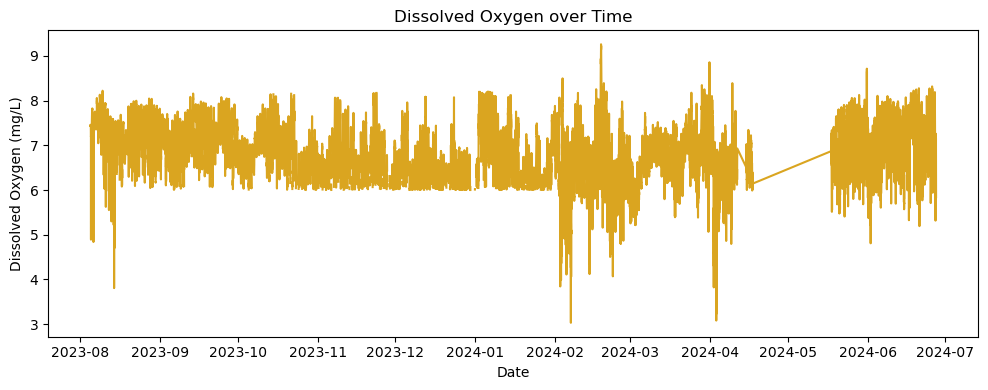

In [4]:
# DO vs Time
plt.figure(figsize=(10,4))
plt.plot(df["Timestamp"], df["Dissolved Oxygen"],  color="goldenrod" )
plt.title("Dissolved Oxygen over Time")
plt.xlabel("Date")
plt.ylabel("Dissolved Oxygen (mg/L)")
plt.tight_layout()
plt.show()

#### Data Time gaps 

In [5]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors='coerce')
df = df.sort_values("Timestamp").reset_index(drop=True)

df["time_diff"] = df["Timestamp"].diff().dt.total_seconds() / 3600  # 转成小时

gaps = df[df["time_diff"] > 1]
print(f"\n {len(gaps)} time gaps > 1 hour")
print(gaps[["Timestamp", "time_diff"]].head(10))


 2 time gaps > 1 hour
                Timestamp   time_diff
24646 2024-04-14 20:20:00   82.666667
25017 2024-05-17 20:50:00  730.833333


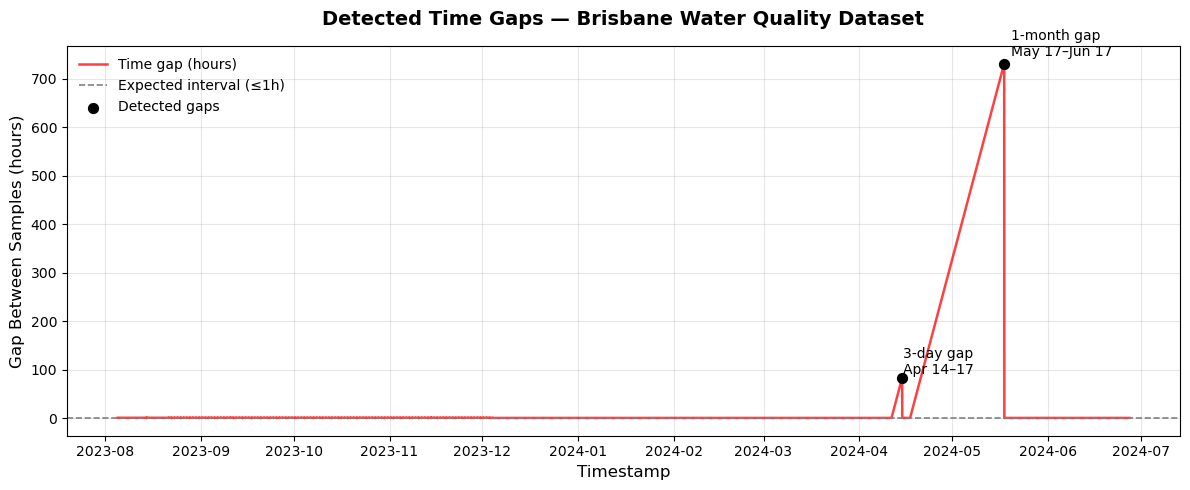

In [6]:
plt.figure(figsize=(12,5))
plt.plot(df["Timestamp"], df["time_diff"], color = 'red', alpha=0.75, lw=1.8, label="Time gap (hours)")
plt.axhline(1, color="gray", linestyle="--", lw=1.2, label="Expected interval (≤1h)")

plt.scatter(df.loc[df["time_diff"] > 1, "Timestamp"],
            df.loc[df["time_diff"] > 1, "time_diff"],
            color="black", s=50, zorder=5, label="Detected gaps")

plt.text(pd.Timestamp("2024-04-15"), 85, "3-day gap\nApr 14–17", fontsize=10, color="black", ha='left', va='bottom')
plt.text(pd.Timestamp("2024-05-20"), 740, "1-month gap\nMay 17–Jun 17", fontsize=10, color="black", ha='left', va='bottom')

plt.title("Detected Time Gaps — Brisbane Water Quality Dataset", fontsize=14, weight='bold', pad=15)
plt.ylabel("Gap Between Samples (hours)", fontsize=12)
plt.xlabel("Timestamp", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(frameon=False, fontsize=10, loc='upper left')
plt.tight_layout()
plt.show()

In [7]:
first_gap_idx = df.index[df["time_diff"] > 1][0]
first_gap_time = df.loc[first_gap_idx, "Timestamp"]

print(f"First gap detected after {first_gap_time}")

df = df.loc[:first_gap_idx - 1].reset_index(drop=True)

print(f"Remaining continuous segment: {len(df)} rows")
print(f"Time range: {df['Timestamp'].min()} → {df['Timestamp'].max()}")

First gap detected after 2024-04-14 20:20:00
Remaining continuous segment: 24646 rows
Time range: 2023-08-04 23:00:00 → 2024-04-11 09:40:00


#### Correlation Overview

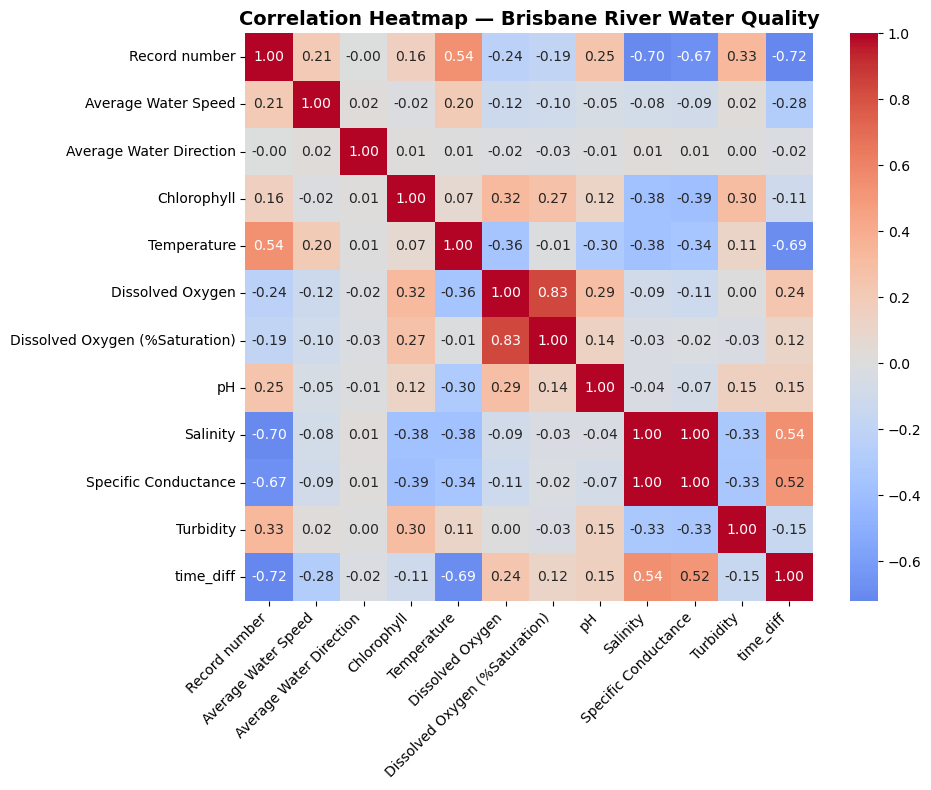

In [8]:
num_df = df.select_dtypes(include=["number"])
corr = num_df.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f", square=True)
plt.title("Correlation Heatmap — Brisbane River Water Quality", fontsize=14, weight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

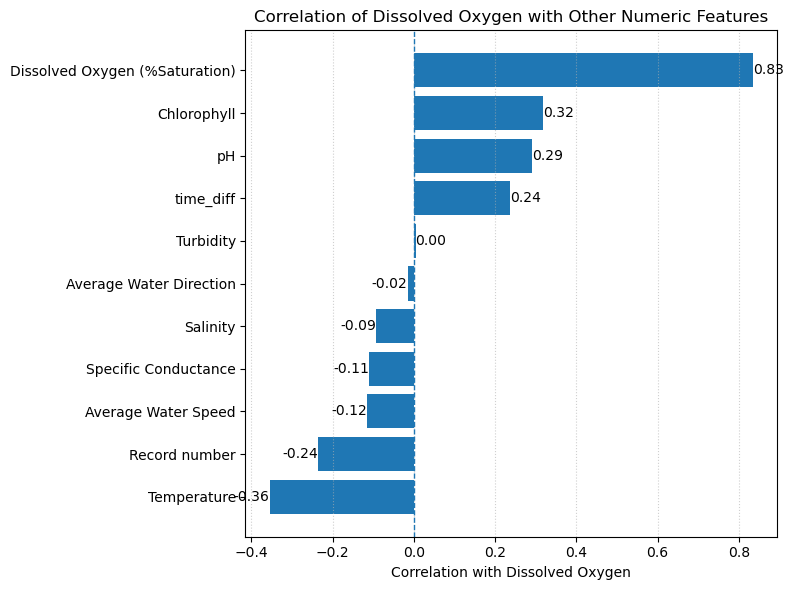

In [9]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
target = "Dissolved Oxygen"
corr_series = df[numeric_cols].corr()[target].drop(labels=[target])

corr_sorted = corr_series.sort_values()

plt.figure(figsize=(8,6))
ax = plt.gca()
bars = ax.barh(corr_sorted.index.astype(str), corr_sorted.values)

ax.axvline(0, linestyle="--", linewidth=1)
ax.set_title("Correlation of Dissolved Oxygen with Other Numeric Features")
ax.set_xlabel("Correlation with Dissolved Oxygen")
ax.grid(axis="x", linestyle=":", alpha=0.6)

try:
    ax.bar_label(bars, fmt="%.2f")
except Exception:
    pass

plt.tight_layout()
plt.show()

#### EDA based on target varibale Dissolved Oxygen

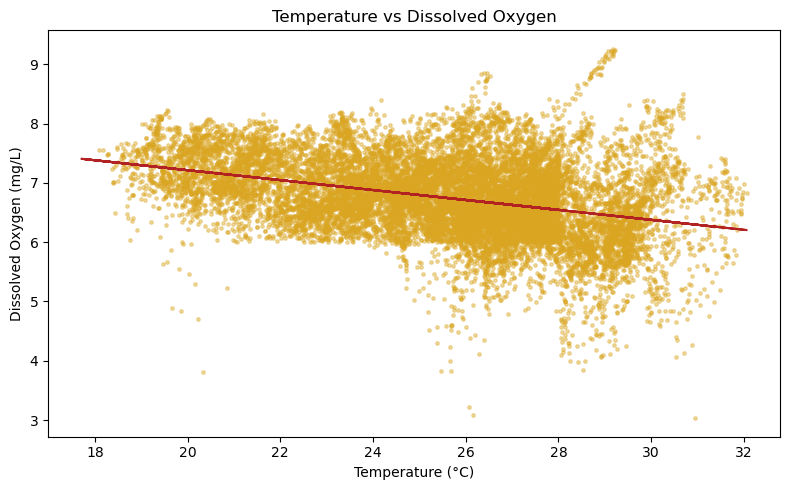

In [10]:
plt.figure(figsize=(8,5))
x = df["Temperature"]
y = df["Dissolved Oxygen"]
plt.scatter(x, y, s=6, alpha=0.4,  color="goldenrod" )

mask = (~pd.isna(x)) & (~pd.isna(y))
coef = np.polyfit(x[mask], y[mask], 1)
poly1d_fn = np.poly1d(coef)
plt.plot(x, poly1d_fn(x),  color="firebrick")

plt.title("Temperature vs Dissolved Oxygen")
plt.xlabel("Temperature (°C)")
plt.ylabel("Dissolved Oxygen (mg/L)")
plt.tight_layout()
plt.show()

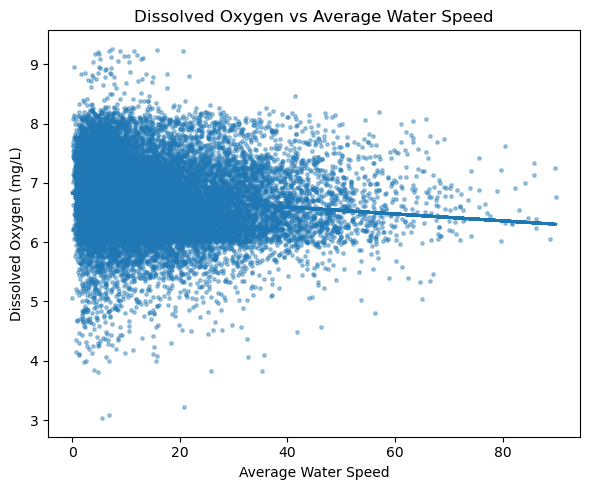

In [11]:
plt.figure(figsize=(6,5))
x = df["Average Water Speed"]
y = df["Dissolved Oxygen"]
plt.scatter(x, y, s=6, alpha=0.4)

mask = (~pd.isna(x)) & (~pd.isna(y))
coef = np.polyfit(x[mask], y[mask], 1)
poly1d_fn = np.poly1d(coef)
plt.plot(x, poly1d_fn(x), linewidth=2)

plt.title("Dissolved Oxygen vs Average Water Speed")
plt.xlabel("Average Water Speed")
plt.ylabel("Dissolved Oxygen (mg/L)")
plt.tight_layout()
plt.show()

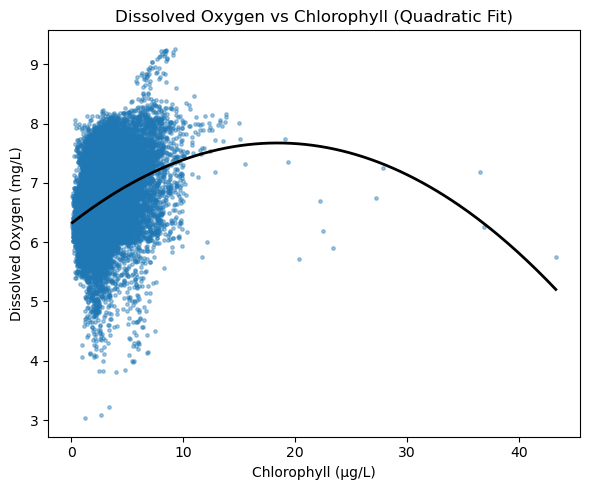

In [12]:
plt.figure(figsize=(6,5))
x = df["Chlorophyll"]
y = df["Dissolved Oxygen"]
plt.scatter(x, y, s=6, alpha=0.4)

mask = (~pd.isna(x)) & (~pd.isna(y))
coef2 = np.polyfit(x[mask], y[mask], 2) 
poly2_fn = np.poly1d(coef2)
x_line = np.linspace(x.min(), x.max(), 200)
plt.plot(x_line, poly2_fn(x_line), linewidth=2, color = 'black')

plt.title("Dissolved Oxygen vs Chlorophyll (Quadratic Fit)")
plt.xlabel("Chlorophyll (µg/L)")
plt.ylabel("Dissolved Oxygen (mg/L)")
plt.tight_layout()
plt.show()

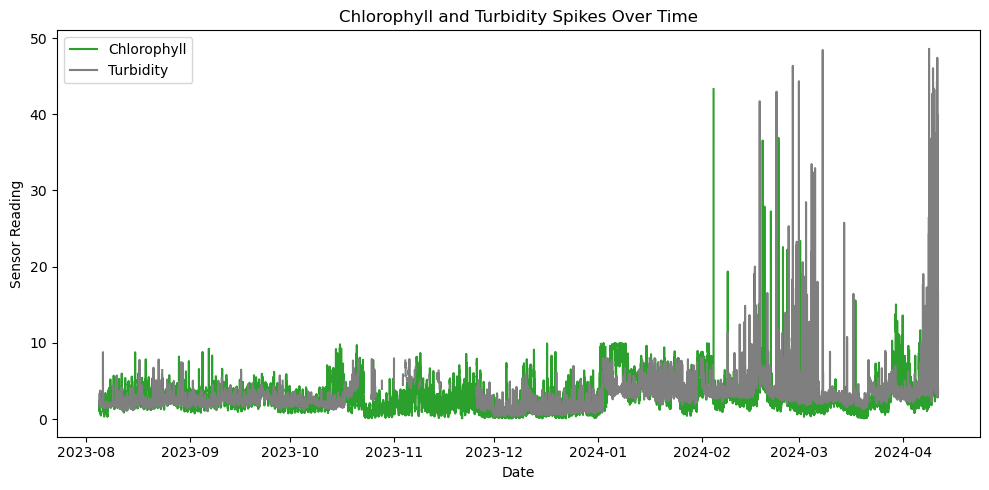

In [13]:
plt.figure(figsize=(10,5))
plt.plot(df["Timestamp"], df["Chlorophyll"], label="Chlorophyll", color='tab:green')
plt.plot(df["Timestamp"], df["Turbidity"], label="Turbidity", color='tab:gray')
plt.legend()
plt.title("Chlorophyll and Turbidity Spikes Over Time")
plt.xlabel("Date")
plt.ylabel("Sensor Reading")
plt.tight_layout()
plt.show()

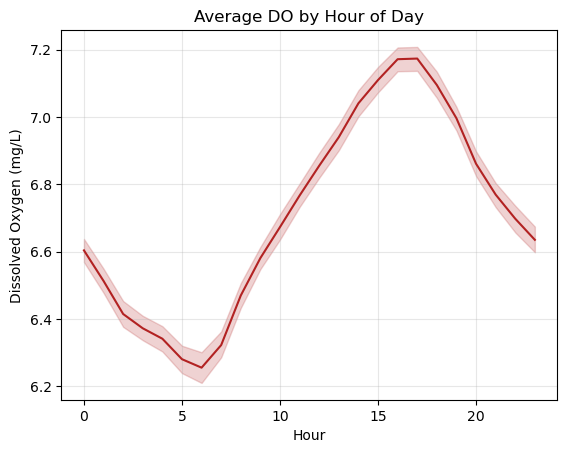

In [14]:
# suprising finding
df["hour"] = pd.to_datetime(df["Timestamp"]).dt.hour
sns.lineplot(x="hour", y="Dissolved Oxygen", data=df, color = 'firebrick')
plt.title("Average DO by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Dissolved Oxygen (mg/L)")
plt.grid(alpha=0.3)

plt.savefig(fig_save / "Average_DO_by_Hour_of_Day.png", dpi=200, bbox_inches="tight")
plt.show()

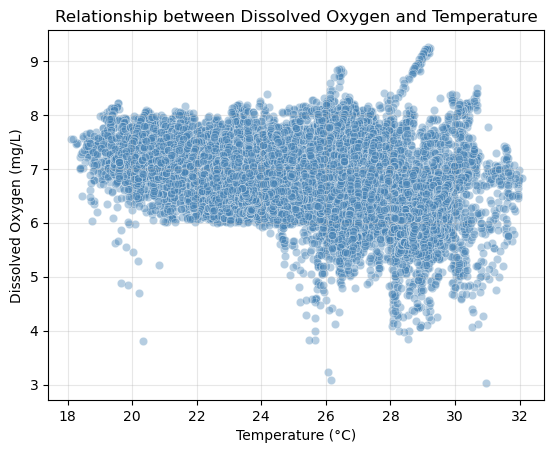

Correlation (Temperature vs DO): -0.355


In [15]:
sns.scatterplot(x="Temperature", y="Dissolved Oxygen", data=df, alpha=0.4, color='steelblue')
plt.title("Relationship between Dissolved Oxygen and Temperature")
plt.xlabel("Temperature (°C)")
plt.ylabel("Dissolved Oxygen (mg/L)")
plt.grid(alpha=0.3)
plt.show()

corr = df["Temperature"].corr(df["Dissolved Oxygen"])
print(f"Correlation (Temperature vs DO): {corr:.3f}")

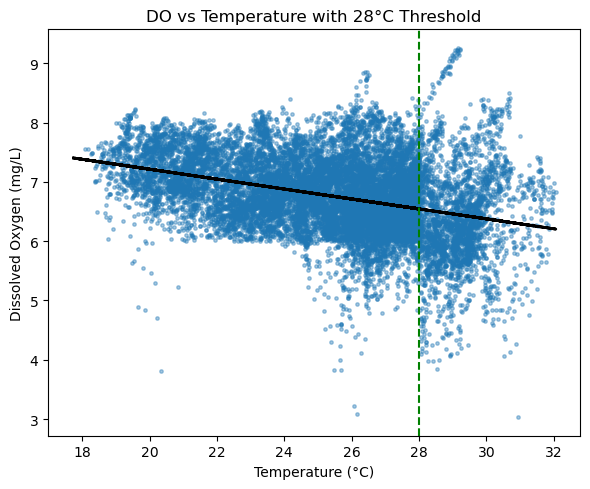

In [16]:
plt.figure(figsize=(6,5))
x = df["Temperature"]
y = df["Dissolved Oxygen"]
plt.scatter(x, y, s=6, alpha=0.4)

mask = (~pd.isna(x)) & (~pd.isna(y))
coef = np.polyfit(x[mask], y[mask], 1)
poly_fn = np.poly1d(coef)
plt.plot(x, poly_fn(x), linewidth=2, color = 'black')

plt.axvline(28, linestyle="--", color = 'green')
plt.title("DO vs Temperature with 28°C Threshold")
plt.xlabel("Temperature (°C)")
plt.ylabel("Dissolved Oxygen (mg/L)")
plt.tight_layout()

plt.show()

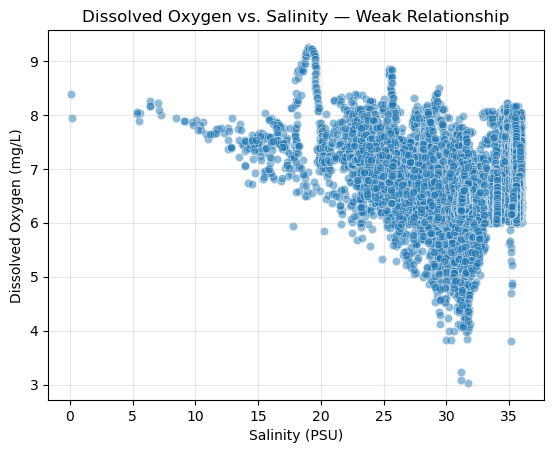

Correlation (Salinity, DO): -0.09249685286766163


In [17]:
sns.scatterplot(x="Salinity", y="Dissolved Oxygen", data=df, alpha=0.5)
plt.title("Dissolved Oxygen vs. Salinity — Weak Relationship")
plt.xlabel("Salinity (PSU)")
plt.ylabel("Dissolved Oxygen (mg/L)")
plt.grid(alpha=0.3)
plt.show()
print("Correlation (Salinity, DO):", df["Salinity"].corr(df["Dissolved Oxygen"]))

≤ 28.0°C  : n=15062,  mean DO=6.815 mg/L,  std=0.575
> 28.0°C  : n=2951, mean DO=6.384 mg/L,  std=0.835
Drop in mean DO above 28.0°C: 6.3%


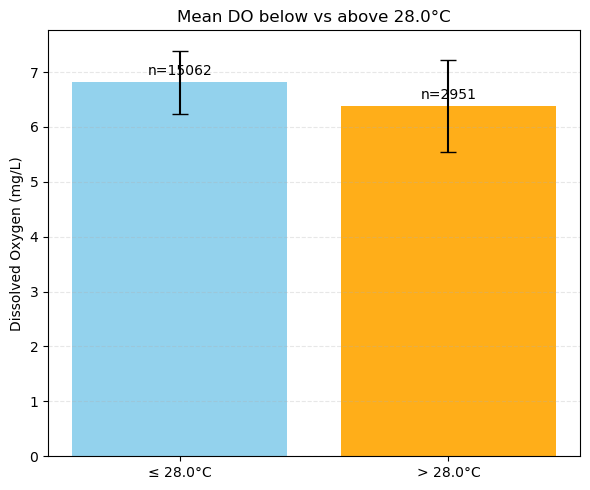

In [18]:
# —— 参数 ——
T_THRESH = 28.0

# —— 分组（自动忽略 NaN） ——
mask_low  = (df["Temperature"] <= T_THRESH) & df["Dissolved Oxygen"].notna() & df["Temperature"].notna()
mask_high = (df["Temperature"] >  T_THRESH) & df["Dissolved Oxygen"].notna() & df["Temperature"].notna()

do_low  = df.loc[mask_low,  "Dissolved Oxygen"]
do_high = df.loc[mask_high, "Dissolved Oxygen"]

# —— 统计量 ——
mean_low,  std_low,  n_low  = do_low.mean(),  do_low.std(ddof=1),  do_low.shape[0]
mean_high, std_high, n_high = do_high.mean(), do_high.std(ddof=1), do_high.shape[0]

print(f"≤ {T_THRESH}°C  : n={n_low},  mean DO={mean_low:.3f} mg/L,  std={std_low:.3f}")
print(f"> {T_THRESH}°C  : n={n_high}, mean DO={mean_high:.3f} mg/L,  std={std_high:.3f}")
if n_low>0 and n_high>0:
    drop_pct = 100*(mean_low-mean_high)/mean_low
    print(f"Drop in mean DO above {T_THRESH}°C: {drop_pct:.1f}%")

fig, ax = plt.subplots(figsize=(6,5))

bars = ax.bar(
    ["≤ "+str(T_THRESH)+"°C", "> "+str(T_THRESH)+"°C"],
    [mean_low, mean_high],
    yerr=[std_low, std_high],
    capsize=6,
    color=['skyblue', 'orange'],
    alpha=0.9
)

for bar, n in zip(bars, [n_low, n_high]):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()*1.01, f"n={n}", ha="center", va="bottom", fontsize=10)

ax.set_ylabel("Dissolved Oxygen (mg/L)")
ax.set_title(f"Mean DO below vs above {T_THRESH}°C")
ax.grid(axis="y", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

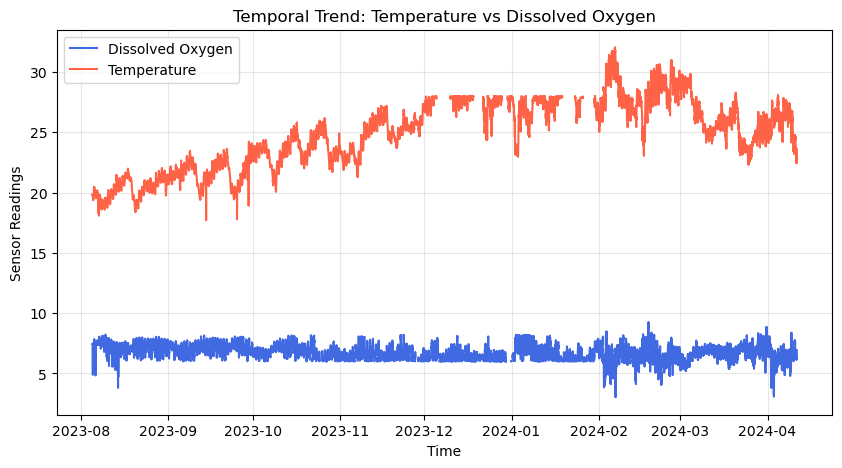

In [19]:
plt.figure(figsize=(10,5))
plt.plot(df["Timestamp"], df["Dissolved Oxygen"], label="Dissolved Oxygen", color='royalblue')
plt.plot(df["Timestamp"], df["Temperature"], label="Temperature", color='tomato')
plt.legend()
plt.title("Temporal Trend: Temperature vs Dissolved Oxygen")
plt.xlabel("Time")
plt.ylabel("Sensor Readings")
plt.grid(alpha=0.3)
plt.show()

Pearson r (DO vs %Sat) = 0.835


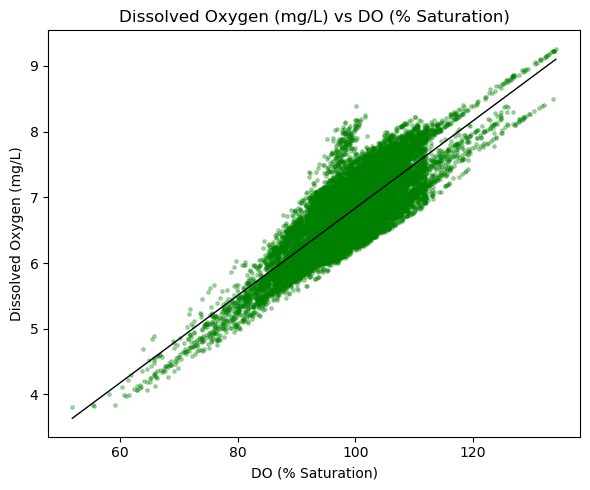

In [20]:
do = df["Dissolved Oxygen"]
dosat = df["Dissolved Oxygen (%Saturation)"]
temp = df["Temperature"]

plt.figure(figsize=(6,5))
plt.scatter(dosat, do, s=6, alpha=0.3, color ='green')
plt.title("Dissolved Oxygen (mg/L) vs DO (% Saturation)")
plt.xlabel("DO (% Saturation)")
plt.ylabel("Dissolved Oxygen (mg/L)")

mask = (~pd.isna(dosat)) & (~pd.isna(do))
coef = np.polyfit(dosat[mask], do[mask], 1)
fit = np.poly1d(coef)
xline = np.linspace(np.nanmin(dosat), np.nanmax(dosat), 200)
plt.plot(xline, fit(xline), linewidth=1, color ='black')

r = np.corrcoef(dosat[mask], do[mask])[0,1]
print(f"Pearson r (DO vs %Sat) = {r:.3f}")

plt.tight_layout()
plt.show()

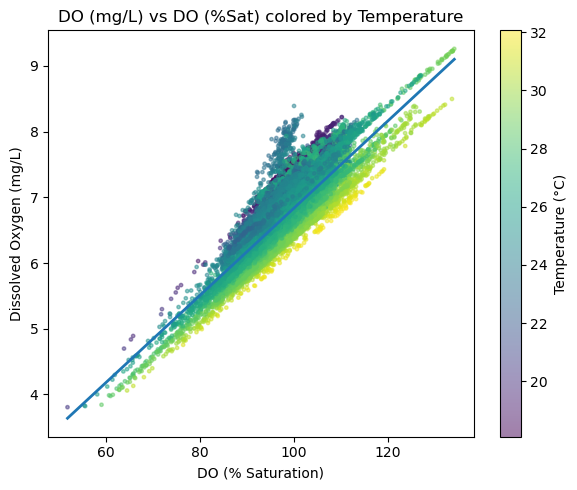

In [21]:
plt.figure(figsize=(6,5))
c = temp
plt.scatter(dosat, do, c=c, s=6, alpha=0.5)
plt.title("DO (mg/L) vs DO (%Sat) colored by Temperature")
plt.xlabel("DO (% Saturation)")
plt.ylabel("Dissolved Oxygen (mg/L)")
cb = plt.colorbar()
cb.set_label("Temperature (°C)")

mask = (~pd.isna(dosat)) & (~pd.isna(do))
coef = np.polyfit(dosat[mask], do[mask], 1)
fit = np.poly1d(coef)
xline = np.linspace(np.nanmin(dosat), np.nanmax(dosat), 200)
plt.plot(xline, fit(xline), linewidth=2)

plt.tight_layout()   
plt.savefig(fig_save / "DO (mg_L)_vs_DO_Sat_colored_by_Temperature.png", dpi=200, bbox_inches="tight")
plt.show()

#### Autocorrelation

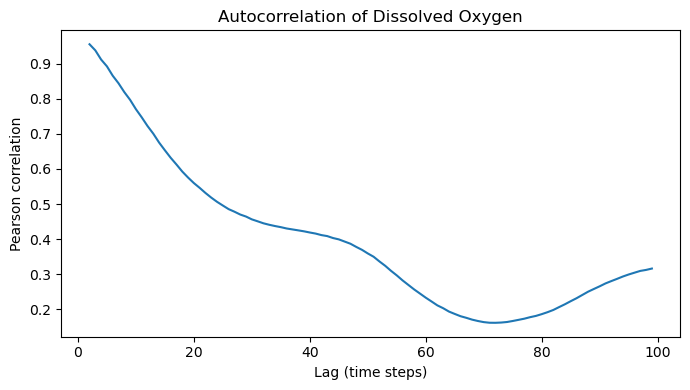

In [22]:
y = df["Dissolved Oxygen"].dropna().reset_index(drop=True)

lags = np.arange(1, 100)
corr_coefs = np.zeros(len(lags))

for i in range(len(lags)):
    x = y.iloc[i:].reset_index(drop=True)
    z = y.iloc[:-i].reset_index(drop=True)
    corr_coefs[i] = x.corr(z)

plt.figure(figsize=(7,4))
plt.plot(lags, corr_coefs)
plt.title("Autocorrelation of Dissolved Oxygen")
plt.xlabel("Lag (time steps)")
plt.ylabel("Pearson correlation")
plt.tight_layout()
plt.show()

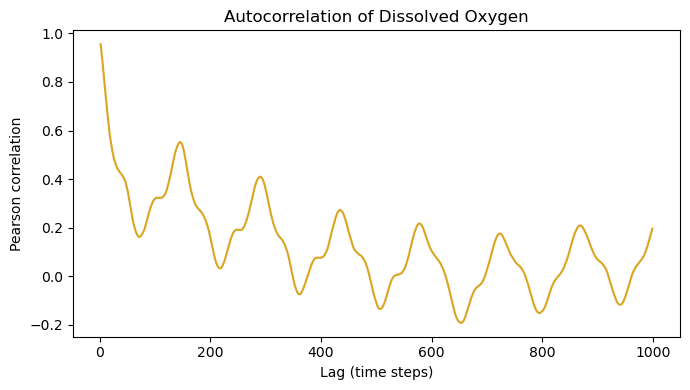

In [23]:
y = df["Dissolved Oxygen"].dropna().reset_index(drop=True)

lags = np.arange(1, 1000)
corr_coefs = np.zeros(len(lags))

for i in range(len(lags)):
    x = y.iloc[i:].reset_index(drop=True)
    z = y.iloc[:-i].reset_index(drop=True)
    corr_coefs[i] = x.corr(z)

plt.figure(figsize=(7,4))
plt.plot(lags, corr_coefs, color = 'goldenrod')
plt.title("Autocorrelation of Dissolved Oxygen")
plt.xlabel("Lag (time steps)")
plt.ylabel("Pearson correlation")
plt.tight_layout()
plt.savefig(str(fig_save / "Autocorrelation of DO.png"),
                dpi=200, bbox_inches="tight")   
plt.show()

<Figure size 800x400 with 0 Axes>

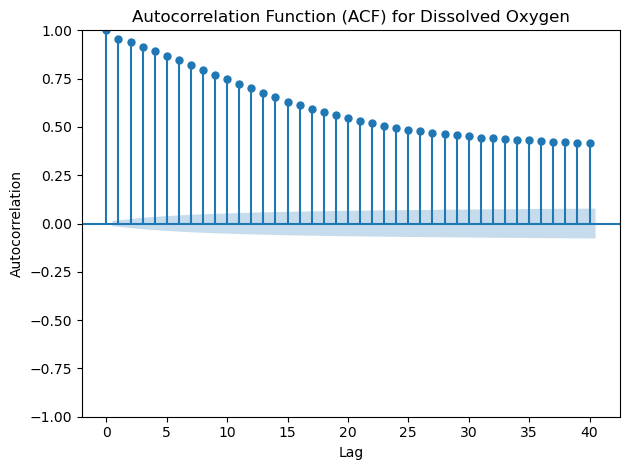

In [24]:
from statsmodels.graphics.tsaplots import plot_acf

y = df["Dissolved Oxygen"].dropna().reset_index(drop=True)
# Autocorrelation Function（ACF）
plt.figure(figsize=(8,4))
plot_acf(y, lags=40)
plt.title("Autocorrelation Function (ACF) for Dissolved Oxygen")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()

### Part 3: Splitting and preprocessing 

In [25]:
vars_vec = [
    "Dissolved Oxygen",
    "Temperature",
    "Salinity",
    "pH",
    "Chlorophyll",
    "Turbidity",
    "Specific Conductance",
    "Average Water Speed",
    "Average Water Direction",
    "Dissolved Oxygen (%Saturation)"
]

p = 15
lagged_blocks = []
for var in vars_vec:
    block = pd.concat([df[var].shift(L) for L in range(p, 0, -1)], axis=1)
    block.columns = [f"{var}_lag{L}" for L in range(p, 0, -1)]
    lagged_blocks.append(block)

X = pd.concat(lagged_blocks, axis=1)
y = df["Dissolved Oxygen"]

X = X.iloc[p:].reset_index(drop=True)
y = y.iloc[p:].reset_index(drop=True)

In [26]:
print("After dropping only the first p rows:")
print("X shape:", X.shape)
print("y shape:", y.shape)

print("Any NaN remaining in X?", X.isna().any().any())
print("Any NaN remaining in y?", y.isna().any())

print("X shape:", X.shape)   # (n_samples, n_features)
print("y shape:", y.shape)   # (n_samples,)
print(X.tail(3))
print(y.tail(3))

After dropping only the first p rows:
X shape: (24631, 150)
y shape: (24631,)
Any NaN remaining in X? True
Any NaN remaining in y? True
X shape: (24631, 150)
y shape: (24631,)
       Dissolved Oxygen_lag15  Dissolved Oxygen_lag14  Dissolved Oxygen_lag13  \
24628                   6.243                   6.268                   6.361   
24629                   6.268                   6.361                   6.117   
24630                   6.361                   6.117                   6.223   

       Dissolved Oxygen_lag12  Dissolved Oxygen_lag11  Dissolved Oxygen_lag10  \
24628                   6.117                   6.223                   6.468   
24629                   6.223                   6.468                   6.229   
24630                   6.468                   6.229                   6.429   

       Dissolved Oxygen_lag9  Dissolved Oxygen_lag8  Dissolved Oxygen_lag7  \
24628                  6.229                  6.429                  6.448   
24629             

#### Splitting

In [27]:
#target_train_ratio = 0.70
#target_val_ratio   = 0.15
#target_test_ratio  = 0.10

target_train_ratio = 0.75
target_val_ratio   = 0.15
target_test_ratio  = 0.10


n_total = len(X)
n_test = int(target_test_ratio * n_total)
n_trainval = n_total - n_test

X_trainval = X.iloc[:n_trainval]
y_trainval = y.iloc[:n_trainval]
X_test = X.iloc[n_trainval:]
y_test = y.iloc[n_trainval:]

val_size = int((target_val_ratio / (1 - target_test_ratio)) * n_trainval)
n_splits = min(10, n_trainval // val_size - 1)
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=val_size)


#### Preprocessing

In [28]:
if "Timestamp" in X.columns:
    X = X.drop(columns=["Timestamp"])
    X_trainval = X_trainval.drop(columns=["Timestamp"])
    X_test = X_test.drop(columns=["Timestamp"])
    print(" Dropped datetime column: 'Timestamp'")

all_cols = X.columns.tolist()
minmax_cols = [c for c in all_cols if ("%Saturation" in c) or ("pH" in c)]
std_cols    = [c for c in all_cols if c not in minmax_cols]

non_numeric = X_trainval.select_dtypes(exclude=[np.number]).columns.tolist()

X_trainval = X_trainval.drop(columns=non_numeric)
X_test     = X_test.drop(columns=[c for c in non_numeric if c in X_test.columns], errors="ignore")

minmax_cols = [c for c in minmax_cols if c in X_trainval.columns]
std_cols    = [c for c in std_cols    if c in X_trainval.columns]

preprocessor = ColumnTransformer(
    transformers=[
        ("std", StandardScaler(), std_cols),
        ("mm",  MinMaxScaler(),   minmax_cols),
    ],
    remainder="drop"
)
pipe = Pipeline([("preprocessor", preprocessor)])

folds_X_train, folds_X_val = [], []
folds_y_train, folds_y_val = [], []
feat_names = None

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_trainval), 1):
    X_tr, X_va = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
    y_tr, y_va = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]

    X_tr_prep = pipe.fit_transform(X_tr)
    X_va_prep = pipe.transform(X_va)

    if feat_names is None:
        feat_names = pipe.named_steps["preprocessor"].get_feature_names_out()

    folds_X_train.append(X_tr_prep)
    folds_X_val.append(X_va_prep)
    folds_y_train.append(y_tr.to_numpy())
    folds_y_val.append(y_va.to_numpy())

    print(f"Fold {fold:>2}: X_train_prep={X_tr_prep.shape}, X_val_prep={X_va_prep.shape}")

print("\n Done: per-fold preprocessing completed.")
print("Feature dimension:", len(feat_names))


Fold  1: X_train_prep=(3698, 150), X_val_prep=(3694, 150)
Fold  2: X_train_prep=(7392, 150), X_val_prep=(3694, 150)
Fold  3: X_train_prep=(11086, 150), X_val_prep=(3694, 150)
Fold  4: X_train_prep=(14780, 150), X_val_prep=(3694, 150)
Fold  5: X_train_prep=(18474, 150), X_val_prep=(3694, 150)

 Done: per-fold preprocessing completed.
Feature dimension: 150


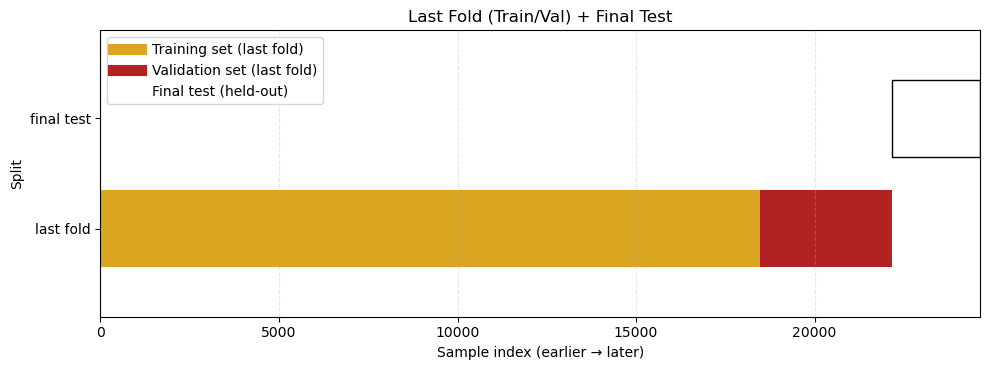

In [29]:
all_splits = list(tscv.split(X_trainval))
last_train_idx, last_val_idx = all_splits[-1]

train_color = "goldenrod"
val_color   = "firebrick"
test_color  = "white"
bg_color    = "white"

fig, ax = plt.subplots(figsize=(10, 3.8))
ax.set_facecolor(bg_color)

y_level = 0
tr_left  = int(last_train_idx[0])
tr_width = int(last_train_idx[-1] - last_train_idx[0] + 1)
va_left  = int(last_val_idx[0])
va_width = int(last_val_idx[-1] - last_val_idx[0] + 1)

ax.broken_barh([(tr_left, tr_width)], (y_level - 0.35, 0.70), facecolors=train_color)
ax.broken_barh([(va_left, va_width)], (y_level - 0.35, 0.70), facecolors=val_color)

y_testrow = 1.0
ax.broken_barh([(n_trainval, n_test)], (y_testrow - 0.35, 0.70), facecolors=test_color, edgecolor = 'black')

ax.set_xlim(0, n_total)
ax.set_ylim(-0.8, 1.8)
ax.set_yticks([y_level, y_testrow])
ax.set_yticklabels(["last fold", "final test"])

ax.set_xlabel("Sample index (earlier → later)")
ax.set_ylabel("Split")
ax.set_title("Last Fold (Train/Val) + Final Test")

train_patch = plt.Line2D([0], [0], color=train_color, lw=8, label="Training set (last fold)")
val_patch   = plt.Line2D([0], [0], color=val_color,   lw=8, label="Validation set (last fold)")
test_patch  = plt.Line2D([0], [0], color=test_color,  lw=8, label="Final test (held-out)")

ax.legend(handles=[train_patch, val_patch, test_patch], loc="upper left")
ax.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

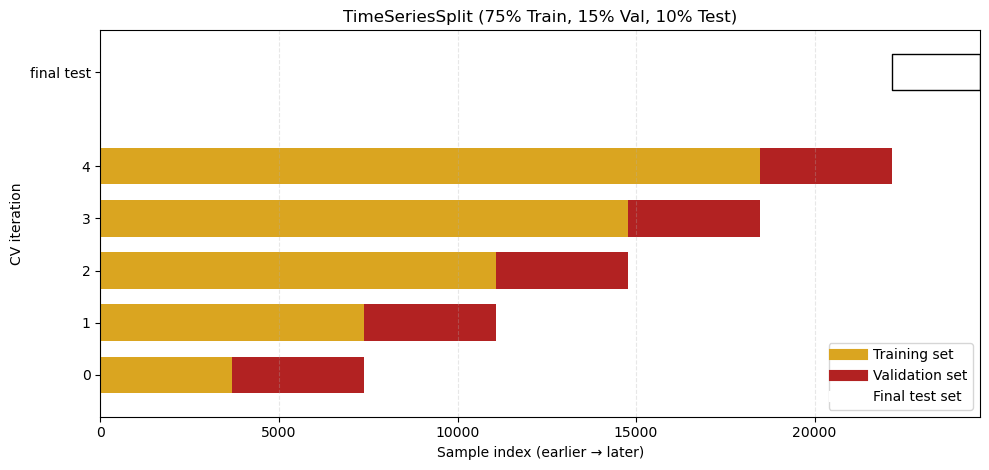

In [30]:
idx_trainval = np.arange(n_trainval)

fig, ax = plt.subplots(figsize=(10, 4.8))
ax.set_facecolor(bg_color)

for fold, (tr_idx, va_idx) in enumerate(tscv.split(X_trainval), 1):
    y_level = fold - 1  

    tr_left  = int(tr_idx[0])
    tr_width = int(tr_idx[-1] - tr_idx[0] + 1)
    ax.broken_barh([(tr_left, tr_width)], (y_level - 0.35, 0.70), facecolors=train_color)

    va_left  = int(va_idx[0])
    va_width = int(va_idx[-1] - va_idx[0] + 1)
    ax.broken_barh([(va_left, va_width)], (y_level - 0.35, 0.70), facecolors=val_color)

y_testrow = (tscv.get_n_splits(X_trainval)) + 0.8
ax.broken_barh([(n_trainval, n_test)], (y_testrow - 0.35, 0.70),
               facecolors=test_color, edgecolor='black')

ax.set_xlim(0, n_total)
ax.set_ylim(-0.8, tscv.get_n_splits(X_trainval) + 1.6)

yticks = list(range(tscv.get_n_splits(X_trainval))) + [y_testrow]
ytick_labels = [str(i) for i in range(tscv.get_n_splits(X_trainval))] + ["final test"]
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels)

ax.set_xlabel("Sample index (earlier → later)")
ax.set_ylabel("CV iteration")

ax.set_title("TimeSeriesSplit (75% Train, 15% Val, 10% Test)")

train_patch = plt.Line2D([0], [0], color=train_color, lw=8, label="Training set")
val_patch   = plt.Line2D([0], [0], color=val_color,   lw=8, label="Validation set")
test_patch  = plt.Line2D([0], [0], color=test_color,     lw=8, label="Final test set")
ax.legend(handles=[train_patch, val_patch, test_patch], loc="lower right")

ax.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig(fig_save / "TimeSeriesSplit (75% Train, 15% Val, 10% Test).png", dpi=200, bbox_inches="tight")
plt.show()


#### Missing Value

In [31]:
from sklearn.base import clone

all_splits = list(tscv.split(X_trainval))
last_train_idx, last_val_idx = all_splits[-1]

X_tr  = X_trainval.iloc[last_train_idx]
y_tr  = y_trainval.iloc[last_train_idx]
X_va  = X_trainval.iloc[last_val_idx]
y_va  = y_trainval.iloc[last_val_idx]

print("=== BEFORE PREPROCESSING ===")
print(f"Train: rows={X_tr.shape[0]:,} , features={X_tr.shape[1]}")
print(f"Val  : rows={X_va.shape[0]:,} , features={X_va.shape[1]}")
print(f"Test : rows={X_test.shape[0]:,} , features={X_test.shape[1]}")

pipe_fold = clone(pipe)
X_tr_prep = pipe_fold.fit_transform(X_tr)   # fit on train of last fold
X_va_prep = pipe_fold.transform(X_va)       # transform val (no fit)
X_test_prep = pipe_fold.transform(X_test)   # transform test (no fit)  

feat_names = pipe_fold.named_steps["preprocessor"].get_feature_names_out()
X_tr_prep_df   = pd.DataFrame(X_tr_prep,   columns=feat_names, index=X_tr.index)
X_va_prep_df   = pd.DataFrame(X_va_prep,   columns=feat_names, index=X_va.index)
X_test_prep_df = pd.DataFrame(X_test_prep, columns=feat_names, index=X_test.index)

print("\n=== AFTER PREPROCESSING (last fold) ===")
print(f"Train: rows={X_tr_prep_df.shape[0]:,} , features={X_tr_prep_df.shape[1]}")
print(f"Val  : rows={X_va_prep_df.shape[0]:,} , features={X_va_prep_df.shape[1]}")
print(f"Test : rows={X_test_prep_df.shape[0]:,} , features={X_test_prep_df.shape[1]}")

print("\n=== SUMMARY (shapes) ===")
summary = [
    ["Before", "Train", X_tr.shape[0],  X_tr.shape[1]],
    ["Before", "Val"  , X_va.shape[0],  X_va.shape[1]],
    ["Before", "Test" , X_test.shape[0],X_test.shape[1]],
    ["After" , "Train", X_tr_prep_df.shape[0],  X_tr_prep_df.shape[1]],
    ["After" , "Val"  , X_va_prep_df.shape[0],  X_va_prep_df.shape[1]],
    ["After" , "Test" , X_test_prep_df.shape[0],X_test_prep_df.shape[1]],
]
for row in summary:
    print(f"{row[0]:<6} {row[1]:<5} rows={row[2]:>8,} , features={row[3]:>5}")

=== BEFORE PREPROCESSING ===
Train: rows=18,474 , features=150
Val  : rows=3,694 , features=150
Test : rows=2,463 , features=150

=== AFTER PREPROCESSING (last fold) ===
Train: rows=18,474 , features=150
Val  : rows=3,694 , features=150
Test : rows=2,463 , features=150

=== SUMMARY (shapes) ===
Before Train rows=  18,474 , features=  150
Before Val   rows=   3,694 , features=  150
Before Test  rows=   2,463 , features=  150
After  Train rows=  18,474 , features=  150
After  Val   rows=   3,694 , features=  150
After  Test  rows=   2,463 , features=  150


In [32]:
common_cols = (X_tr_prep_df.columns.intersection(X_va_prep_df.columns).intersection(X_test_prep_df.columns))
X_final_all = pd.concat([X_tr_prep_df[common_cols], X_va_prep_df[common_cols], X_test_prep_df[common_cols]],axis=0, ignore_index=True)

frac_rows_any_nan = X_final_all.isna().any(axis=1).mean() * 100
frac_feats_any_nan = (X_final_all.isna().sum() > 0).mean() * 100

print("Missing value overview:")
print(f"  Fraction of rows with ≥1 missing value: {frac_rows_any_nan:.3f}%")
print(f"  Fraction of features with missing values: {frac_feats_any_nan:.3f}%")

total_nan_cells = int(X_final_all.isna().sum().sum())
print(f"  Shapes: rows={len(X_final_all):,}, features={X_final_all.shape[1]}")
print(f"  Total missing cells: {total_nan_cells:,}")

Missing value overview:
  Fraction of rows with ≥1 missing value: 55.832%
  Fraction of features with missing values: 100.000%
  Shapes: rows=24,631, features=150
  Total missing cells: 351,765


In [33]:
base_vars = sorted(set(c.split("_lag")[0] for c in X.columns if "_lag" in c))
rep_cols = [f"{v}_lag1" for v in base_vars if f"{v}_lag1" in X.columns]

missing_summary = (X[rep_cols].isna().sum().to_frame("Missing Count").assign(Missing_Percent = X[rep_cols].isna().mean() * 100))

missing_summary.index = [c.replace("_lag1", "") for c in missing_summary.index]

missing_summary = missing_summary.sort_values("Missing_Percent", ascending=False)
print("=== Missing Value Summary (One Representative Lag per Variable) ===")
print(missing_summary.to_string(float_format="%.2f"))


=== Missing Value Summary (One Representative Lag per Variable) ===
                                Missing Count  Missing_Percent
Dissolved Oxygen (%Saturation)           5742            23.31
Temperature                              4468            18.14
Dissolved Oxygen                         4293            17.43
Salinity                                 3952            16.04
Turbidity                                1963             7.97
Specific Conductance                     1361             5.53
pH                                       1078             4.38
Chlorophyll                               578             2.35
Average Water Speed                        15             0.06
Average Water Direction                     1             0.00


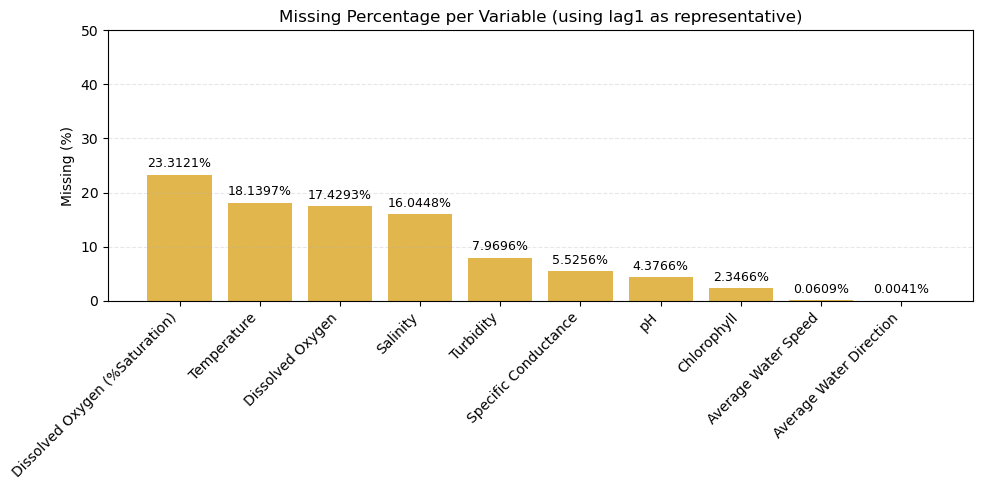

In [34]:
plt.figure(figsize=(10, 5))
bars = plt.bar(
    missing_summary.index,
    missing_summary["Missing_Percent"],
    color="goldenrod",
    alpha=0.8
)

plt.xticks(rotation=45, ha='right')
plt.ylabel("Missing (%)")
plt.title("Missing Percentage per Variable (using lag1 as representative)")
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.ylim(0, 50)

for bar, pct in zip(bars, missing_summary["Missing_Percent"]):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.8,               
        f"{pct:.4f}%",               
        ha='center', va='bottom',
        fontsize=9, color='black'
    )

plt.tight_layout()
plt.savefig(
    fig_save / "Missing Percentage per Variable (using lag1 as representative).png",
    dpi=200,
    bbox_inches="tight"
)
plt.show()